# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
from src.unilm import *

In [9]:
config = unilm_config(vocab)

In [10]:
# # config['n_layers'] = 8
# # config['dec_layers'] = 0
# config['n_layers'] = 2
# config['dec_layers'] = 2
# config['mem_len'] = 512
# config['rand_bptt'] = False
# config['bptt'] = 512
# config['bs'] = 8


In [11]:
config

{'ctx_len': 150,
 'n_layers': 8,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 137),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 312,
 'dec_layers': 8}

In [12]:
base_path = Path('../../data/midi/v17/sf4/')

In [13]:
cache_name = 'tmp/hook_c'
# cache_name = 'tmp/sample'

## BERT Dataloading

In [14]:
ns_dl_tfms = [mask_tfm, next_sentence_tfm]
ns_config = config.copy()
ns_config['bs'] *= 2
ns_data = load_music_data(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
                          y_offset=0, dl_tfms=ns_dl_tfms, **ns_config)

In [15]:
xb,yb = ns_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([32, 256]),
 torch.Size([32, 256]),
 torch.Size([32, 256]),
 torch.Size([32, 256])]

## S2S Dataloading

In [16]:
s2s_dl_tfms = [s2s_tfm]
s2s_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                           preloader_cls=S2SPreloader, dl_tfms=s2s_dl_tfms, y_offset=1,
                           shuffle_dl=True, **config)


In [17]:
s2s_data.train_dl.dl.dataset.on_epoch_begin()
s2s_data.train_dl.dl.dataset.on_epoch_end()
xb,yb = s2s_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256])]

### Load NextWord dataset (Language Model)

In [18]:

nw_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, 
                              vocab=vocab, dl_tfms=[nw_tfm], y_offset=1, 
                              train_tfms=[to_single_stream], valid_tfms=[to_single_stream], **config)
nw_data.vocab = vocab

## Datasets

In [19]:
datasets = [nw_data, s2s_data, ns_data]
# datasets = [nw_data]

In [20]:
ns_data.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fe425476780>, device=device(type='cuda'), tfms=[<function mask_tfm at 0x7fe3849ad048>, <function next_sentence_tfm at 0x7fe384992f28>], collate_fn=<function data_collate at 0x7fe3962adea0>)

## Load

In [21]:
def predict_func(parts): return [p if idx == 1 else F.softmax(p, dim=-1) for idx,p in enumerate(parts)]
# Need to monkey patch pred_batch activation function for 2d array
loss_func_name = camel2snake(BertLoss.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func

In [22]:
loss_func = BertLoss(loss_mult=(1,1,1,1))
learn = bert_model_learner(datasets[0], config.copy(), 
                           loss_func=loss_func)

# model = get_bert_model(config['vocab_size'], config=config.copy())
# learn = BertLearner(datasets[0], model, config=config, split_func=None, loss_func=loss_func)

In [23]:
learn.metrics = [mask_acc, nw_acc, s2s_acc, ns_acc]

In [24]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]
learn.callbacks.append(BertTrainer(learn, datasets))

In [25]:
[type(c) for c in learn.callbacks]

[src.unilm.BertTrainer]

In [26]:
learn = learn.to_fp16()

### Training

In [27]:
# learn.fit_one_cycle(12, 1e-4)

## Load existing

In [28]:
base_path/'models/unilm'

PosixPath('../../data/midi/v17/sf4/models/unilm')

In [29]:
saved_models = get_files(base_path/'piano_duet/models/unilm', recurse=True, extensions=['.pth']); saved_models

[PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/4_ep90_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/4_ep90.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/5_ep40_reencode_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/3_ep30_full_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/3_ep30_full.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/5_ep40_reencode.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/5_ep40_reencode_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/1_ep60.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/6_ep40_reencode.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/6_ep40_reencode_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/1_ep60_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/m

In [30]:
load_path = saved_models[8]
state = torch.load(load_path, map_location='cpu')
get_model(learn.model).load_state_dict(state['model'])
load_path

PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/6_ep40_reencode.pth')

## Prediction

Prediction algo

In [31]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,section,ht_key,song_url,midi,artist,md5,numpy,ht_offset,title,midi_title,parts,genres,mxl,source,ht_mode,ht_time_signature,ht_bpm
193208,chorus,C,https://www.hooktheory.com/theorytab/view/ritc...,midi_sources/hooktheory/pianoroll/r/ritchie-va...,ritchie-valen,aeee134e4034e5f98bb630c56d2f7f8c,sf4/piano_duet/hooktheory/pianoroll/r/ritchie-...,0.0,la-bamba,La Bamba,chorus,"Pop,Rock",NaN,hooktheory_c,1.0,4.0,144.0


In [32]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v17/sf4/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v17/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [33]:
seed_len = 40
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [34]:
# seed_stream = npenc2stream(seed_np)
# seed_stream.show()

In [35]:
xb

tensor([[  0,   1,   8, 147,  64, 139,   8, 139,  66, 139,   8, 139,  68, 139,
           8, 139,  69, 141,  64, 145,  61, 145,  57, 145,   8, 141,  73, 139,
           8, 139,  76, 139,   8, 139,  74, 139,  69, 145,  66, 145,  62, 145,
           8, 139,  74, 139,   8, 139,  78, 139,   8, 139,  76, 141,   8, 139,
          59, 145,  56, 145,  52, 145,   8, 139,  64, 139,   8, 139,  68, 139,
           8, 139,  71, 139,   8, 139,  74, 139,  69, 145,  66, 145]],
       device='cuda:0')

In [36]:
# task_type = torch.full_like(xb, TaskType.NextWord.value)

# learn.model.reset()

# res = learn.pred_batch(batch=((xb,task_type,xb),xb)); res

# preds = loss_batch(learn.model.eval(), (xb,task_type,xb), yb); preds

In [37]:
# last = res[-1][0, -1]; last[143]
# idx = torch.multinomial(res[-1][0, -1], 1).item(); idx

In [38]:
out_s, seed_s = learn.predict_nw(xb, n_words=400)

Predicted BOS token. Returning prediction...


In [39]:
vocab.textify(out_s)

'n53 d8 xxsep d2 n65 d2 xxsep d2 n65 d2 xxsep d2 n64 d4 xxsep d2 n55 d8 n52 d8 n48 d8 xxsep d2 n60 d2 xxsep d2 n64 d2 xxsep d2 n67 d2 xxsep d2 n65 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n65 d2 xxsep d2 n69 d2 xxsep d2 n67 d4 xxsep d2 n50 d8 n47 d8 n43 d8 xxsep d2 n55 d2 xxsep d2 n59 d2 xxsep d2 n62 d2 xxsep d2 n65 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n65 d2 xxsep d2 n65 d2 xxsep d2 n64 d8 xxsep d2 n55 d8 n52 d8 n48 d8 xxsep d8 n65 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n65 d2 xxsep d2 n65 d2 xxsep d2 n64 d2 xxsep d2 n60 d4 n55 d4 n52 d4 n48 d4 xxsep d6 n55 d2 xxsep d2 n60 d2 n55 d8 n52 d8 n48 d8 xxsep d2 n60 d2 xxsep d2 n64 d2 xxsep d2 n67 d2 xxsep d2 n65 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n65 d2 xxsep d2 n69 d2 xxsep d2 n67 d4 xxsep d2 n50 d8 n47 d8 n43 d8 xxsep d2 n55 d2 xxsep d2 n59 d2 xxsep d2 n62 d2 xxsep d2 n65 d2 n60 d8 n57 d8 n53 d8 xxsep d2 n65 d2 xxsep d2 n65 d2 xxsep d2 n64 d4 xxsep d2 n55 d8 n52 d8 n48 d8 xxsep d2 n60 d2 xxsep d2 n64 d2 xxsep d2 n67 d2 xxsep d2 n65 d2 n60 d8 n57 d8 n53 d8 xx

In [40]:
test_out = to_double_stream(out_s); test_out

array([[53,  8],
       [-1,  2],
       [65,  2],
       [-1,  2],
       ...,
       [-1,  2],
       [55,  4],
       [52,  4],
       [48,  4]])

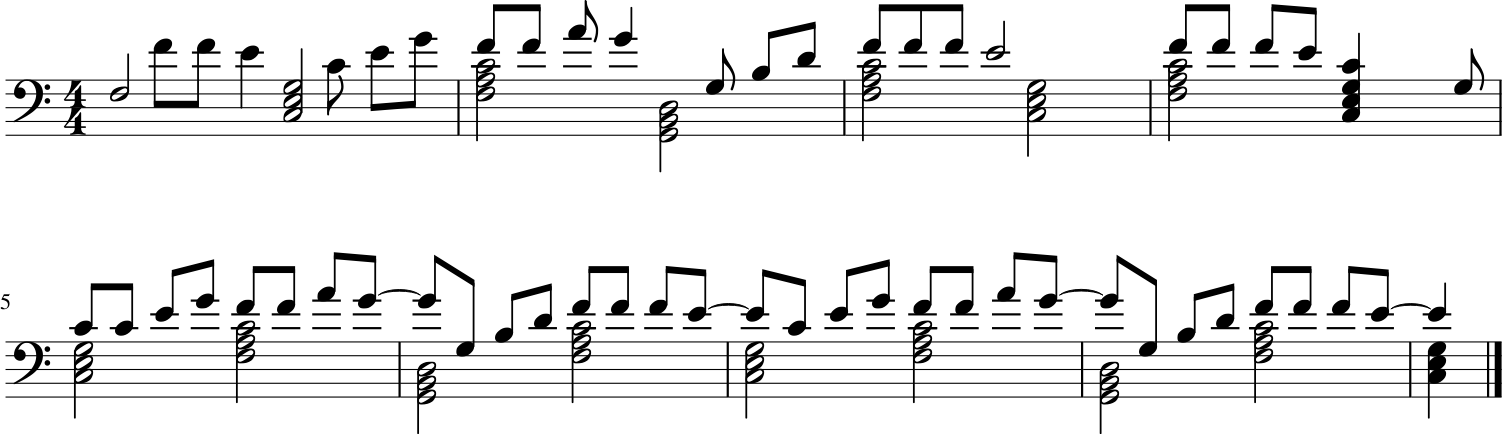

In [41]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()

In [42]:
stream.show('midi')

## Predict Seq2Seq

In [36]:
csv_path = base_path/f's2s_encode/s2s_encode.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('')==True
artist_filter = df['artist'].str.contains('peas')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,7,9,11,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ht_mode,title,genres,source,section,midi,artist,parts,ht_bpm,midi_title,ht_time_signature,ht_key,ht_offset,md5,song_url,numpy,mxl
181259,1.0,i-gotta-feeling,"Electronic,Pop",hooktheory_c,chorus,midi_sources/hooktheory/pianoroll/b/black-eyed...,black-eyed-peas,chorus,128.0,I Gotta Feeling,4.0,C,0.0,2c304797f562ad50ece38859a44d34bc,https://www.hooktheory.com/theorytab/view/blac...,sf4/s2s_encode/hooktheory/pianoroll/b/black-ey...,NaN
181260,1.0,rock-that-body,"Electronic,Pop",hooktheory_c,chorus,midi_sources/hooktheory/pianoroll/b/black-eyed...,black-eyed-peas,chorus,124.0,Rock that body,4.0,C,0.0,36a8823555c7ecbe0982641f6713a353,https://www.hooktheory.com/theorytab/view/blac...,sf4/s2s_encode/hooktheory/pianoroll/b/black-ey...,NaN
181261,1.0,meet-me-halfway,NaN,hooktheory_c,chorus,midi_sources/hooktheory/pianoroll/b/black-eyed...,black-eyed-peas,chorus,130.0,meet me halfway,4.0,C,0.0,f041041b14ac63e610ad3836a3007c8e,https://www.hooktheory.com/theorytab/view/blac...,sf4/s2s_encode/hooktheory/pianoroll/b/black-ey...,NaN
181262,1.0,lets-get-it-started,Hip-Hop/Rap,hooktheory_c,chorus,midi_sources/hooktheory/pianoroll/b/black-eyed...,black-eyed-peas,chorus,104.0,New Project,4.0,C,0.0,fa0da35426b0cc69b52f533cad32c52d,https://www.hooktheory.com/theorytab/view/blac...,sf4/s2s_encode/hooktheory/pianoroll/b/black-ey...,NaN
181263,1.0,just-cant-get-enough,"Alternative,Pop",hooktheory_c,chorus,midi_sources/hooktheory/pianoroll/b/black-eyed...,black-eyed-peas,chorus,88.0,Just Can't Get Enough,4.0,C,0.0,6c6f8c17401c607036629980de5b380c,https://www.hooktheory.com/theorytab/view/blac...,sf4/s2s_encode/hooktheory/pianoroll/b/black-ey...,NaN


In [37]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v17/sf4/s2s_encode/hooktheory/pianoroll/b/black-eyed-peas/i-gotta-feeling/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v17/midi_sources/hooktheory/pianoroll/b/black-eyed-peas/i-gotta-feeling/chorus_key_cmajor.mid'))

In [38]:
from src.midi_data import *

In [39]:
mf = file2mf(orig)

In [40]:
e = [e for t in mf.tracks for e in t.events if e.type == 'SET_TEMPO'][0]
e.data

b"\x07'\r"

In [41]:
# e.data.decode()

In [42]:
file2stream(orig).show('midi')

In [ ]:
melody_np, chord_np = s2s_file2parts

In [ ]:

def part_enc(chordarr, part):
    partarr = chordarr[:,part:part+1,:]
    npenc = chordarr2npenc(partarr)
    return npenc
    

In [236]:
melody_np, chord_np = np.load(file, allow_pickle=True)

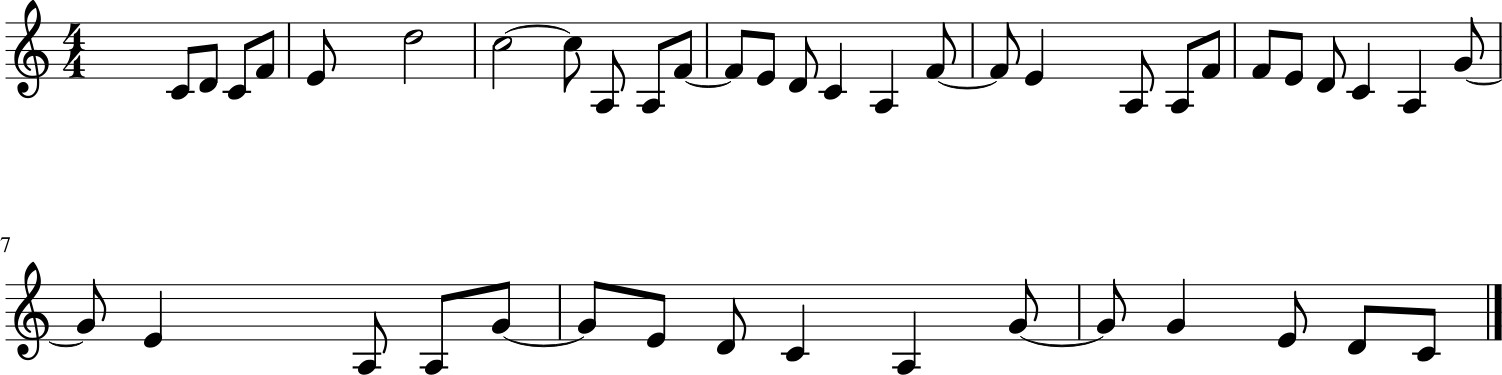

In [237]:
npenc2stream(melody_np).show()

In [238]:
m, c = s2s_file2parts(file, pred_melody=True)
xb = torch.tensor(c)[None].cuda()
yb = torch.tensor(m)[None].cuda()

In [239]:
# c, m = s2s_file2parts(file, pred_melody=False)
# xb = torch.tensor(c)[None].cuda()
# yb = torch.tensor(m)[None].cuda()

In [240]:
# yb_seed = yb[:,:3]
# pad = xb.shape[-1]-yb_seed.shape[-1]

In [241]:
def predict_s2s(self, xb:Tensor, yb:Tensor, n_words:int=128,
                temperature:float=1.0, min_p:float=None):
    if xb.shape[0] > 1: xb = xb[0][None]
#     yb_seed = yb[:, :5]
    yb_seed = yb
    self.model.reset()
    self.model.update_mem_len(TaskType.Seq2Seq.value)

    for i in progress_bar(range(n_words), leave=True):
        task_type = torch.full_like(xb, TaskType.Seq2Seq.value)
        pad = xb.shape[-1]-yb_seed.shape[-1]
        yb_inp = F.pad(yb_seed, (0,pad), value=vocab.pad_idx)

        # Sequence 2 Sequence
        pred_idx = yb_seed.shape[-1]-1
        res = self.pred_batch(batch=((xb,task_type,yb_inp),yb_inp))[-1][0, pred_idx] # task1, task2 - (bs x ts x vocab)

        if min_p is not None: 
            if (res >= min_p).float().sum() == 0: warn(f"No item w/ probability >= {min_p}.")
            else: res[res < min_p] = 0.

        # Use first temperatures value if last prediction was duration
        res.pow_(1 / temperature)
        idx = torch.multinomial(res, 1).item()
#         idx = res.argmax()

        t_idx = torch.tensor(idx, device=xb.device).view(1, 1)
        yb_seed = torch.cat((yb_seed, t_idx), dim=-1)

    return yb_seed

In [242]:
# yb_out = learn.predict_s2s(xb, yb, n_words=250)

In [264]:
yb_out = predict_s2s(learn, xb, yb[:,:30], n_words=250)

In [265]:
seed_npenc = to_double_stream(xb.cpu().numpy())
yb_npenc = to_double_stream(yb_out.cpu().numpy())

Non midi note detected. Only returning valid portion. Index, seed 98 (136, 2)


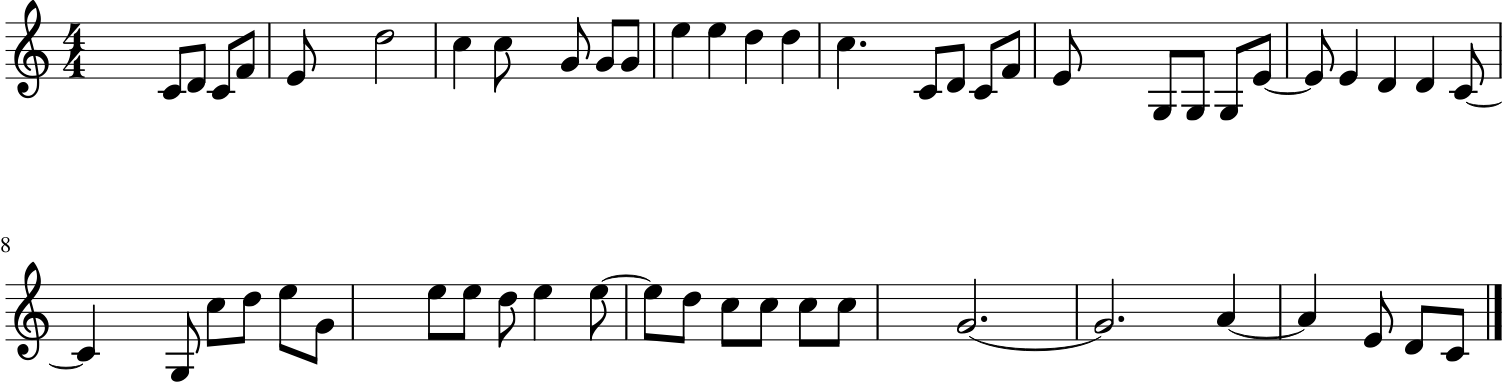

In [266]:
npenc2stream(yb_npenc).show()

In [267]:
npenc2stream(yb_npenc).show('midi')

In [268]:
# chordarr_comb = combined_npenc2chordarr(yb_test, melody_np)
chordarr_comb = combined_npenc2chordarr(yb_npenc, seed_npenc)

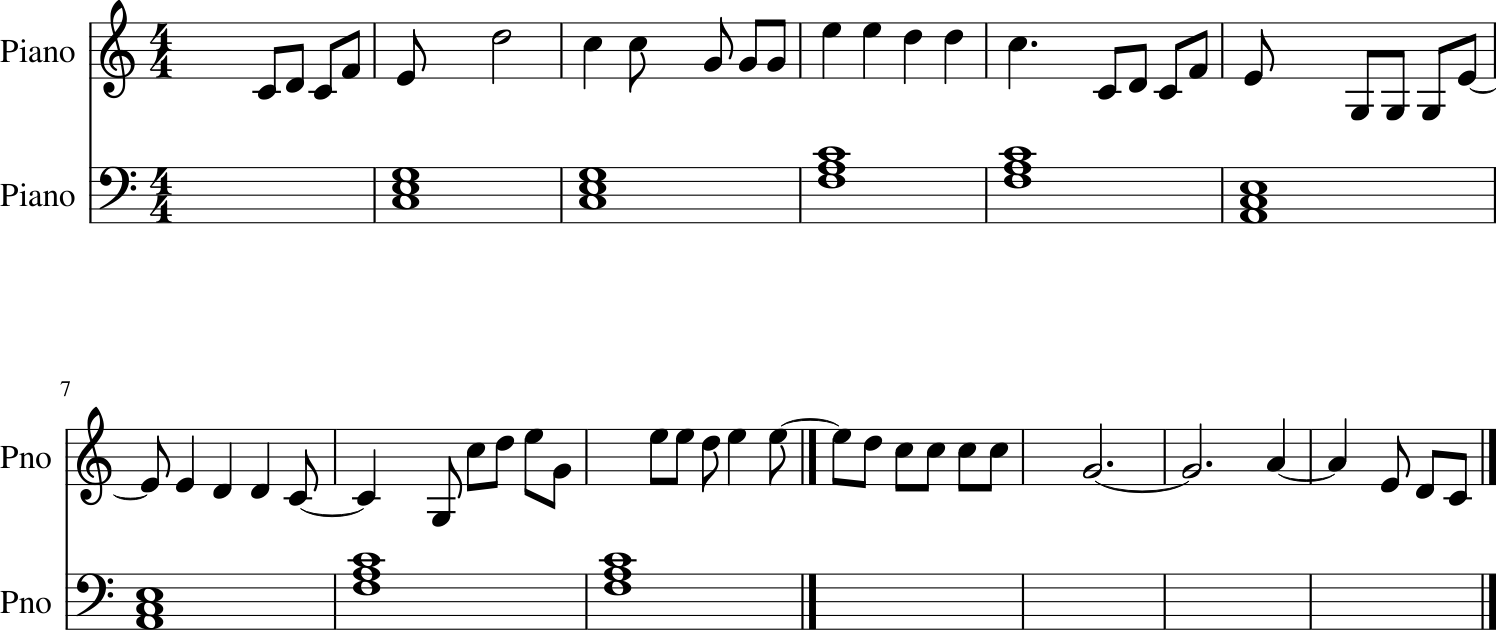

In [269]:
chordarr2stream(chordarr_comb, bpm=108).show()

In [270]:
chordarr2stream(chordarr_comb, bpm=108).show('midi')